
# Exoplanet Baseline Models — 75/25 Split (GB, XGBoost, LightGBM)

This notebook trains and evaluates three classifiers on the Kepler KOI transit + host-star features:

- **GradientBoostingClassifier** (scikit-learn)  
- **XGBClassifier** (XGBoost)  
- **LGBMClassifier** (LightGBM)

It uses a **75/25 train/test split**, prints metrics, plots confusion matrices, shows feature importances,
and saves each model (with metadata) as a **pickle (.pkl)** for later use.

> **Note:** If `xgboost` or `lightgbm` are missing in your environment, the install cell below attempts to install them.


In [1]:

# If running locally and these aren't installed, uncomment the lines below.
# It’s okay if installation fails in offline environments; XGBoost/LightGBM cells will be skipped.
try:
    import xgboost  # noqa: F401
except Exception:
    try:
        %pip install xgboost -q
    except Exception as e:
        print("xgboost install failed or not permitted in this environment:", e)

try:
    import lightgbm  # noqa: F401
except Exception:
    try:
        %pip install lightgbm -q
    except Exception as e:
        print("lightgbm install failed or not permitted in this environment:", e)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:

import os
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import GradientBoostingClassifier

# Optional imports guarded for environments where packages are not available
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False
    print("XGBoost not available — skipping XGBoost model.")

try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False
    print("LightGBM not available — skipping LightGBM model.")


In [3]:

# === Config ===
data_path = "data/Kepler Object of Interest.xlsx"  # change to your file
target_col = "koi_disposition"
feature_cols = [
    "koi_period","koi_time0bk","koi_duration","koi_depth",
    "koi_prad","koi_teq","koi_steff","koi_slogg","koi_srad","koi_kepmag"
]

# Load data: auto-detect Excel vs CSV by extension
ext = os.path.splitext(data_path)[1].lower()
if ext in [".xls", ".xlsx"]:
    df = pd.read_excel(data_path)
else:
    df = pd.read_csv(data_path)

# Keep only target + features and drop rows with missing values
df = df[[target_col] + feature_cols].dropna()

display(df.head())
print("Rows:", len(df))


,koi_disposition,koi_period,koi_time0bk,koi_duration,koi_depth,koi_prad,koi_teq,koi_steff,koi_slogg,koi_srad,koi_kepmag
0,CONFIRMED,9.488036,170.538750,2.95750,615.8,2.26,793.0,5455.0,4.467,0.927,15.347
1,CONFIRMED,54.418383,162.513840,4.50700,874.8,2.83,443.0,5455.0,4.467,0.927,15.347
2,CANDIDATE,19.899140,175.850252,1.78220,10829.0,14.60,638.0,5853.0,4.544,0.868,15.436
3,FALSE POSITIVE,1.736952,170.307565,2.40641,8079.2,33.46,1395.0,5805.0,4.564,0.791,15.597
4,CONFIRMED,2.525592,171.595550,1.65450,603.3,2.75,1406.0,6031.0,4.438,1.046,15.509


Rows: 9200


In [4]:

# Encode target
le = LabelEncoder()
y = le.fit_transform(df[target_col].astype(str))
X = df[feature_cols].apply(pd.to_numeric, errors="coerce").values

# Class mapping & distribution
print("Class mapping:", dict(zip(le.classes_, range(len(le.classes_)))))
unique, counts = np.unique(y, return_counts=True)
print("Class distribution:", dict(zip(le.classes_, counts)))


Class mapping: {'CANDIDATE': 0, 'CONFIRMED': 1, 'FALSE POSITIVE': 2}
Class distribution: {'CANDIDATE': np.int64(1875), 'CONFIRMED': np.int64(2744), 'FALSE POSITIVE': np.int64(4581)}


In [5]:

# 75/25 train/test split (stratified if multiple classes)
stratify_opt = y if len(np.unique(y)) > 1 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=stratify_opt
)
print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (6900, 10)  Test: (2300, 10)


In [10]:
# ================================================
# 📦 Save test data for future app-based evaluation
# ================================================
import os

# Create data folder if not exists
os.makedirs("data/koi_testing_sample", exist_ok=True)

# Convert to DataFrame for readability
X_test_df = pd.DataFrame(X_test, columns=feature_cols)
y_test_labels = le.inverse_transform(y_test)
y_test_df = pd.DataFrame({
    "koi_disposition": y_test_labels
})

# Save both to CSV for app loading
X_test_path = "data/koi_testing_sample/X_test.csv"
y_test_path = "data/koi_testing_sample/y_test.csv"

X_test_df.to_csv(X_test_path, index=False)
y_test_df.to_csv(y_test_path, index=False)

print(f"💾 Saved test feature sample: {X_test_path}")
print(f"💾 Saved test labels: {y_test_path}")

💾 Saved test feature sample: data/koi_testing_sample/X_test.csv
💾 Saved test labels: data/koi_testing_sample/y_test.csv


In [6]:

models = {
    "gradient_boosting": GradientBoostingClassifier(random_state=42),
}

if HAS_XGB:
    models["xgboost"] = XGBClassifier(
        random_state=42,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="mlogloss"
    )

if HAS_LGBM:
    models["lightgbm"] = LGBMClassifier(
        random_state=42,
        n_estimators=600,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=31,
        subsample=0.9,
        colsample_bytree=0.9
    )
    
list(models.keys())


['gradient_boosting', 'xgboost', 'lightgbm']

In [7]:

def evaluate_and_save(name, model, X_tr, y_tr, X_te, y_te, feature_cols, label_encoder, target_col):
    # Train
    model.fit(X_tr, y_tr)
    # Predict
    pred = model.predict(X_te)
    # Metrics
    acc = accuracy_score(y_te, pred)
    print(f"\n=== {name.upper()} ===")
    print(f"Accuracy (75/25): {acc:.3f}")
    print(classification_report(y_te, pred, target_names=label_encoder.classes_))
    # Confusion Matrix
    cm = confusion_matrix(y_te, pred, labels=range(len(label_encoder.classes_)))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_).plot(xticks_rotation=45)
    plt.title(f"Confusion Matrix — {name.replace('_',' ').title()}")
    plt.tight_layout()
    plt.show()

    # Feature Importances (if available)
    try:
        importances = model.feature_importances_
        fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
        display(fi.to_frame("importance"))
        plt.figure()
        fi.plot(kind="bar")
        plt.ylabel("Importance")
        plt.title(f"Feature Importances — {name.replace('_',' ').title()}")
        plt.tight_layout()
        plt.show()
    except Exception:
        print("No feature_importances_ available for this model.")

    # Save model bundle
    out_dir = Path("models")
    out_dir.mkdir(exist_ok=True)
    bundle = {
        "model_name": name,
        "model": model,
        "label_encoder": label_encoder,
        "classes_": label_encoder.classes_,
        "feature_cols": feature_cols,
        "target_col": target_col
    }
    pkl_path = out_dir / f"{name}.pkl"
    with open(pkl_path, "wb") as f:
        pickle.dump(bundle, f)
    print(f"Saved: {pkl_path.resolve()}")



=== GRADIENT_BOOSTING ===
Accuracy (75/25): 0.750
                precision    recall  f1-score   support

     CANDIDATE       0.56      0.46      0.50       469
     CONFIRMED       0.75      0.83      0.79       686
FALSE POSITIVE       0.82      0.82      0.82      1145

      accuracy                           0.75      2300
     macro avg       0.71      0.70      0.70      2300
  weighted avg       0.74      0.75      0.74      2300



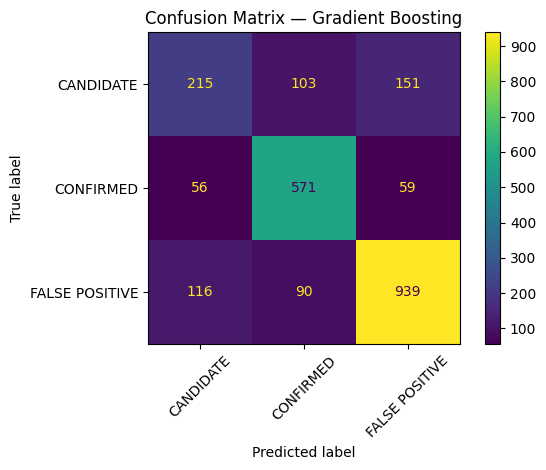

,importance
koi_prad,0.351817
koi_period,0.261176
koi_depth,0.118511
koi_duration,0.101129
koi_teq,0.055393
koi_kepmag,0.039952
koi_steff,0.029236
koi_slogg,0.016175
koi_srad,0.013344
koi_time0bk,0.013267


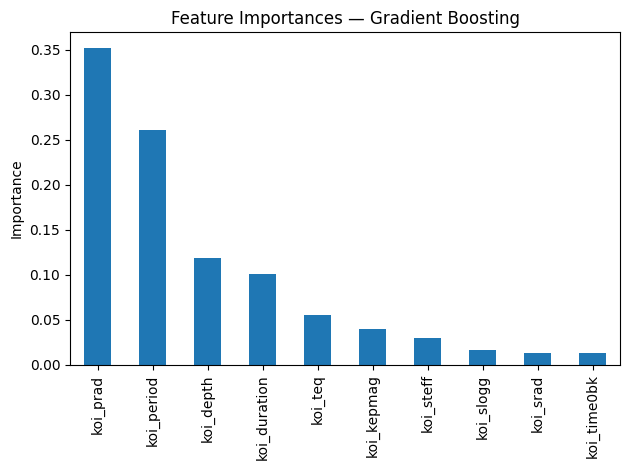

Saved: C:\Roger\goals\creating\blog\NASA-Space-Apps\models\gradient_boosting.pkl

=== XGBOOST ===
Accuracy (75/25): 0.766
                precision    recall  f1-score   support

     CANDIDATE       0.58      0.48      0.53       469
     CONFIRMED       0.77      0.84      0.80       686
FALSE POSITIVE       0.83      0.84      0.83      1145

      accuracy                           0.77      2300
     macro avg       0.73      0.72      0.72      2300
  weighted avg       0.76      0.77      0.76      2300



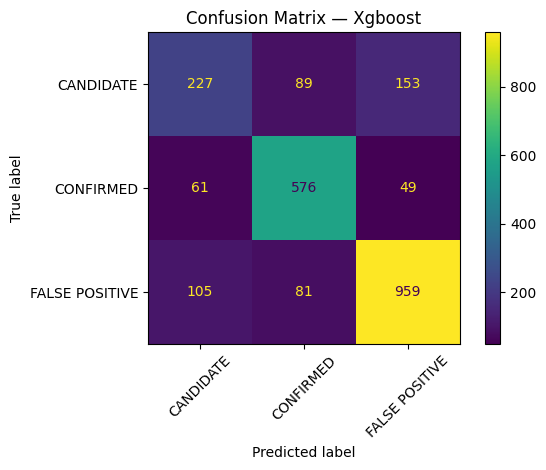

,importance
koi_prad,0.264538
koi_period,0.174836
koi_depth,0.111565
koi_teq,0.100057
koi_duration,0.085795
koi_steff,0.058933
koi_kepmag,0.058736
koi_srad,0.056898
koi_slogg,0.051880
koi_time0bk,0.036764


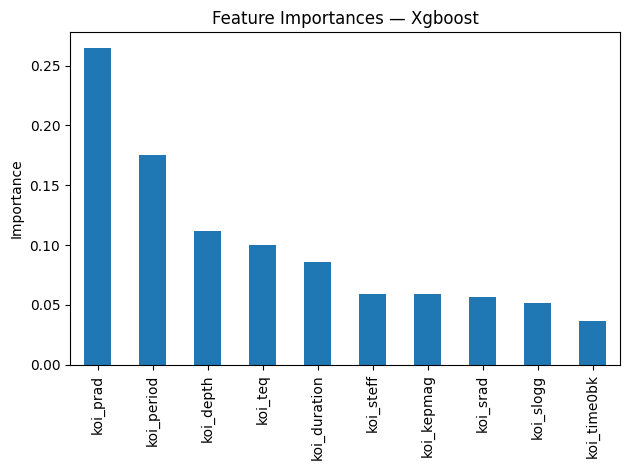

Saved: C:\Roger\goals\creating\blog\NASA-Space-Apps\models\xgboost.pkl
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 6900, number of used features: 10
[LightGBM] [Info] Start training from score -1.590773
[LightGBM] [Info] Start training from score -1.209787
[LightGBM] [Info] Start training from score -0.697213


c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== LIGHTGBM ===
Accuracy (75/25): 0.756
                precision    recall  f1-score   support

     CANDIDATE       0.55      0.48      0.51       469
     CONFIRMED       0.78      0.81      0.80       686
FALSE POSITIVE       0.81      0.84      0.83      1145

      accuracy                           0.76      2300
     macro avg       0.71      0.71      0.71      2300
  weighted avg       0.75      0.76      0.75      2300



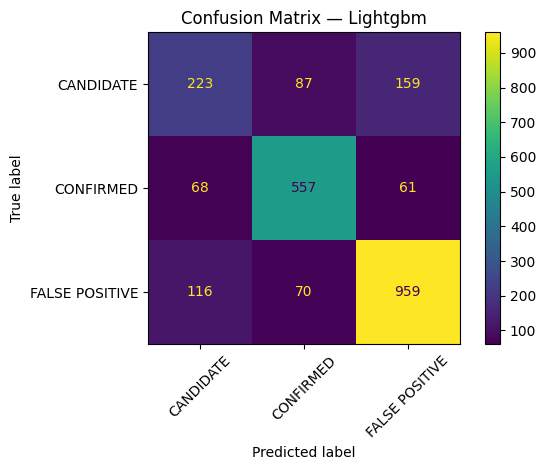

,importance
koi_duration,6864
koi_kepmag,6183
koi_depth,5763
koi_steff,5653
koi_period,5572
koi_prad,5395
koi_time0bk,5280
koi_teq,4749
koi_srad,4391
koi_slogg,4150


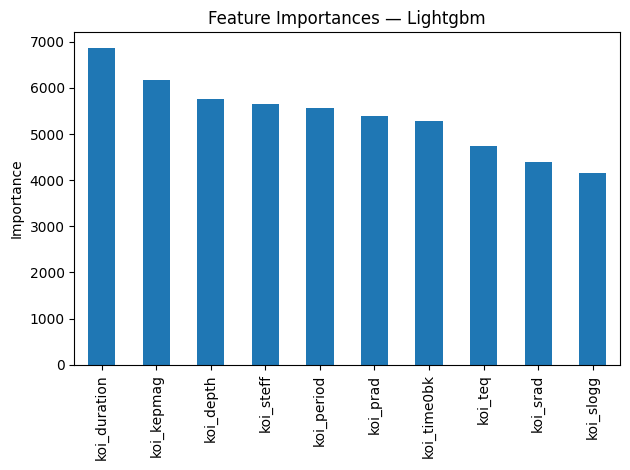

Saved: C:\Roger\goals\creating\blog\NASA-Space-Apps\models\lightgbm.pkl


In [8]:

for name, mdl in models.items():
    evaluate_and_save(name, mdl, X_train, y_train, X_test, y_test, feature_cols, le, target_col)


In [9]:

# Example: Load a saved pickle and run predict on a small batch (first 5 rows of X_test)
from pathlib import Path
import pickle

example_model = "gradient_boosting"  # change to 'xgboost' or 'lightgbm' if available
pkl_path = Path("models") / f"{example_model}.pkl"

if pkl_path.exists():
    with open(pkl_path, "rb") as f:
        bundle = pickle.load(f)
    mdl = bundle["model"]
    fe_cols = bundle["feature_cols"]
    le_loaded = bundle["label_encoder"]
    
    # Predict and map back to class names
    y_pred = mdl.predict(X_test[:5])
    print("Pred (encoded):", y_pred)
    print("Pred (labels):", le_loaded.inverse_transform(y_pred))
else:
    print(f"Model pickle not found at: {pkl_path}")


Pred (encoded): [1 2 1 2 2]
Pred (labels): ['CONFIRMED' 'FALSE POSITIVE' 'CONFIRMED' 'FALSE POSITIVE'
 'FALSE POSITIVE']


In [ ]:

# (Optional) You can extend the loop above to collect metrics into a DataFrame and save as CSV.
# Example skeleton for future use:
# results = []
# for name, mdl in models.items():
#     ... after computing acc and report ...
#     results.append({"model": name, "accuracy": acc})
# pd.DataFrame(results).to_csv("models/metrics_summary.csv", index=False)
# print("Saved metrics to models/metrics_summary.csv")
